In [14]:
from db_con import DatabaseConnection
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.widgets import Slider
import scipy.stats
from matplotlib import ticker
import numpy as np
from matplotlib import rc
#from fitter import get_distributions
import warnings
warnings.filterwarnings("ignore")


In [15]:
query1 = """SELECT percentile_cont(0.25) WITHIN GROUP (ORDER BY one.avg_v) FROM (SELECT AVG(velo) as avg_v FROM accels WHERE velo > 0.2 AND velo != 'NaN' AND velo < 15 GROUP BY filename) as one"""
query2 = """SELECT percentile_cont(0.75) WITHIN GROUP (ORDER BY one.avg_v) FROM (SELECT AVG(velo) as avg_v FROM accels WHERE velo > 0.2 AND velo != 'NaN' AND velo < 15 GROUP BY filename) as one"""

with DatabaseConnection() as cur:
    cur.execute(f"""
        SELECT two.filename, two.avg_v, two.max_v, one.accel, one.decel, CASE WHEN two.avg_v < ({query1}) THEN 0 ELSE CASE WHEN two.avg_v < ({query2}) THEN 1 ELSE 2 END END as group FROM (
                SELECT filename, MAX(accel) as accel, MIN(accel) as decel FROM accels GROUP BY filename
            ) as one JOIN (
                SELECT filename, SUM(velo * duration)/SUM(duration) as avg_v, MAX(velo) as max_v FROM accels WHERE velo > 0.2 AND velo != 'NaN' and velo < 15 GROUP BY filename
            ) as two ON (one.filename = two.filename)""")

    objs = cur.fetchall()


In [16]:
pdf_all = pd.DataFrame(objs, columns=['file', 'avg_speed', 'max_speed', 'max_accel', 'max_decel', 'group'])
print(pdf_all.info)

pdf_avg_all = pdf_all[['file', 'avg_speed']].sort_values('avg_speed').reset_index()
pdf_max_all = pdf_all[['file', 'max_speed']].sort_values('max_speed').reset_index()
pdf_acc_all = pdf_all.query('max_accel >= 0.3')[['file', 'max_accel']].sort_values('max_accel').reset_index()
pdf_dec_all = pdf_all.query('max_decel < -0.1')[['file', 'max_decel']].sort_values('max_decel').reset_index()

pdf_avg_0 = pdf_all.query('group == 0')[['file', 'avg_speed']].sort_values('avg_speed').reset_index()
pdf_max_0 = pdf_all.query('group == 0')[['file', 'max_speed']].sort_values('max_speed').reset_index()
pdf_acc_0 = pdf_all.query('group == 0 and max_accel >= 0.3')[['file', 'max_accel']].sort_values('max_accel').reset_index()
pdf_dec_0 = pdf_all.query('group == 0 and max_decel < -0.1')[['file', 'max_decel']].sort_values('max_decel').reset_index()

pdf_avg_1 = pdf_all.query('group == 1')[['file', 'avg_speed']].sort_values('avg_speed').reset_index()
pdf_max_1 = pdf_all.query('group == 1')[['file', 'max_speed']].sort_values('max_speed').reset_index()
pdf_acc_1 = pdf_all.query('group == 1 and max_accel >= 0.3')[['file', 'max_accel']].sort_values('max_accel').reset_index()
pdf_dec_1 = pdf_all.query('group == 1 and max_decel < -0.1')[['file', 'max_decel']].sort_values('max_decel').reset_index()

pdf_avg_2 = pdf_all.query('group == 2')[['file', 'avg_speed']].sort_values('avg_speed').reset_index()
pdf_max_2 = pdf_all.query('group == 2')[['file', 'max_speed']].sort_values('max_speed').reset_index()
pdf_acc_2 = pdf_all.query('group == 2 and max_accel >= 0.3')[['file', 'max_accel']].sort_values('max_accel').reset_index()
pdf_dec_2 = pdf_all.query('group == 2 and max_decel < -0.1')[['file', 'max_decel']].sort_values('max_decel').reset_index()

lower_bound = 0.05
upper_bound = 0.95
print("all max_v range:({},{})".format(pdf_max_all.iloc[int(lower_bound * len(pdf_max_all)),2],pdf_max_all.iloc[int(upper_bound * len(pdf_max_all)),2]))
print("all max_a range:({},{})".format(pdf_acc_all.iloc[int(lower_bound * len(pdf_acc_all)),2],pdf_acc_all.iloc[int(upper_bound * len(pdf_acc_all)),2]))
print("all max_d range:({},{})".format(pdf_dec_all.iloc[int(lower_bound * len(pdf_dec_all)),2],pdf_dec_all.iloc[int(upper_bound * len(pdf_dec_all)),2]))
print("0 max_v range:({},{})".format(pdf_max_0.iloc[int(lower_bound * len(pdf_max_0)),2],pdf_max_0.iloc[int(upper_bound * len(pdf_max_0)),2]))
print("0 max_a range:({},{})".format(pdf_acc_0.iloc[int(lower_bound * len(pdf_acc_0)),2],pdf_acc_0.iloc[int(upper_bound * len(pdf_acc_0)),2]))
print("0 max_d range:({},{})".format(pdf_dec_0.iloc[int(lower_bound * len(pdf_dec_0)),2],pdf_dec_0.iloc[int(upper_bound * len(pdf_dec_0)),2]))
print("1 max_v range:({},{})".format(pdf_max_1.iloc[int(lower_bound * len(pdf_max_1)),2],pdf_max_1.iloc[int(upper_bound * len(pdf_max_1)),2]))
print("1 max_a range:({},{})".format(pdf_acc_1.iloc[int(lower_bound * len(pdf_acc_1)),2],pdf_acc_1.iloc[int(upper_bound * len(pdf_acc_1)),2]))
print("1 max_d range:({},{})".format(pdf_dec_1.iloc[int(lower_bound * len(pdf_dec_1)),2],pdf_dec_1.iloc[int(upper_bound * len(pdf_dec_1)),2]))
print("2 max_v range:({},{})".format(pdf_max_2.iloc[int(lower_bound * len(pdf_max_2)),2],pdf_max_2.iloc[int(upper_bound * len(pdf_max_2)),2]))
print("2 max_a range:({},{})".format(pdf_acc_2.iloc[int(lower_bound * len(pdf_acc_2)),2],pdf_acc_2.iloc[int(upper_bound * len(pdf_acc_2)),2]))
print("2 max_d range:({},{})".format(pdf_dec_2.iloc[int(lower_bound * len(pdf_dec_2)),2],pdf_dec_2.iloc[int(upper_bound * len(pdf_dec_2)),2]))

# print("all max_v range:({},{})".format(pdf_max_all.iloc[0,2],pdf_max_all.iloc[len(pdf_max_all)-1,2]))
# print("all max_a range:({},{})".format(pdf_acc_all.iloc[0,2],pdf_acc_all.iloc[len(pdf_acc_all)-1,2]))
# print("all max_d range:({},{})".format(pdf_dec_all.iloc[0,2],pdf_dec_all.iloc[len(pdf_dec_all)-1,2]))
# print("0 max_v range:({},{})".format(pdf_max_0.iloc[0,2],pdf_max_0.iloc[len(pdf_max_0)-1,2]))
# print("0 max_a range:({},{})".format(pdf_acc_0.iloc[0,2],pdf_acc_0.iloc[len(pdf_acc_0)-1,2]))
# print("0 max_d range:({},{})".format(pdf_dec_0.iloc[0,2],pdf_dec_0.iloc[len(pdf_dec_0)-1,2]))
# print("1 max_v range:({},{})".format(pdf_max_1.iloc[0,2],pdf_max_1.iloc[len(pdf_max_1)-1,2]))
# print("1 max_a range:({},{})".format(pdf_acc_1.iloc[0,2],pdf_acc_1.iloc[len(pdf_acc_1)-1,2]))
# print("1 max_d range:({},{})".format(pdf_dec_1.iloc[0,2],pdf_dec_1.iloc[len(pdf_dec_1)-1,2]))
# print("2 max_v range:({},{})".format(pdf_max_2.iloc[0,2],pdf_max_2.iloc[len(pdf_max_2)-1,2]))
# print("2 max_a range:({},{})".format(pdf_acc_2.iloc[0,2],pdf_acc_2.iloc[len(pdf_acc_2)-1,2]))
# print("2 max_d range:({},{})".format(pdf_dec_2.iloc[0,2],pdf_dec_2.iloc[len(pdf_dec_2)-1,2]))


b1 = 15.71#3.6 * pdf_avg.iloc[int(0.25 * len(pdf_avg))]['avg_speed']
b2 = 20.41#3.6 * pdf_avg.iloc[int(0.75 * len(pdf_avg))]['avg_speed']
def plot_graph(pdf_local: pd.Series, label_name: str, vlines: bool, n_bins:int, density:bool, x_lim_0: float, x_lim_1: float, y_lim_0: float, y_lim_1: float):
    # mn, mx = plt.xlim()
    # plt.hist(pdf_local * 3.6, n_bins, range=(mn, mx), density=False, histtype='step')
    # plt.hist(pdf_local, n_bins, range=(mn, mx), density=False, histtype='step', label=label_name)

    rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 16})
    rc('text', usetex=True)
    plt.hist(pdf_local, bins=n_bins, density=density, label=label_name, histtype='step')

    plt.xlim(x_lim_0, x_lim_1)
    plt.ylim(y_lim_0, y_lim_1)

    # kde_xs = np.linspace(mn, mx, 200)
    # kde_avg = scipy.stats.gaussian_kde(pdf_local)#put data in linear regression -> plot formula
    # plt.plot(kde_xs, ((mx - mn) / n_bins * len(pdf_local)) * kde_avg.pdf(kde_xs), label=label_name)
    if vlines:
        plt.vlines([pdf_local.iloc[int(0.25 * len(pdf_local))], pdf_local.iloc[int(0.75 * len(pdf_local))]], 0, 10000, colors='r')

<bound method DataFrame.info of                   file  avg_speed  max_speed  max_accel  max_decel  group
0      VM2_-1076932297   3.517851   4.615646   0.728855  -0.716483      0
1      VM2_-1433400869   3.360708   5.973860  -0.002239  -0.280976      0
2       VM2_-347812378   5.136926   6.801638   0.713941  -1.124583      2
3       VM2_1292996248   4.638050   6.529581   1.176907  -1.062969      1
4       VM2_1604289110   5.703885   9.980326   1.137777  -0.959080      2
...                ...        ...        ...        ...        ...    ...
51917   VM2_-470131887   5.486947  10.195197   1.202513  -1.193721      2
51918  VM2_-1719766590   4.769797   7.142891   1.101334  -1.117784      1
51919   VM2_1979508389   4.113726   5.453779   0.668506  -0.768166      1
51920   VM2_1907687803   3.707322   5.639380   1.088712  -0.653739      0
51921  VM2_-1316720421   2.754343   4.005811   0.008695  -0.370119      0

[51922 rows x 6 columns]>
all max_v range:(4.2069885748321285,9.336903005295177

In [17]:
# Number of rides after importing
with DatabaseConnection() as cur:
    cur.execute(""" SELECT COUNT(*) FROM ride """)
    number_of_rides_response = cur.fetchall()

print("number of all rides in \"ride\" table:{}".format(number_of_rides_response[0][0]))

number of all rides in "ride" table:58639


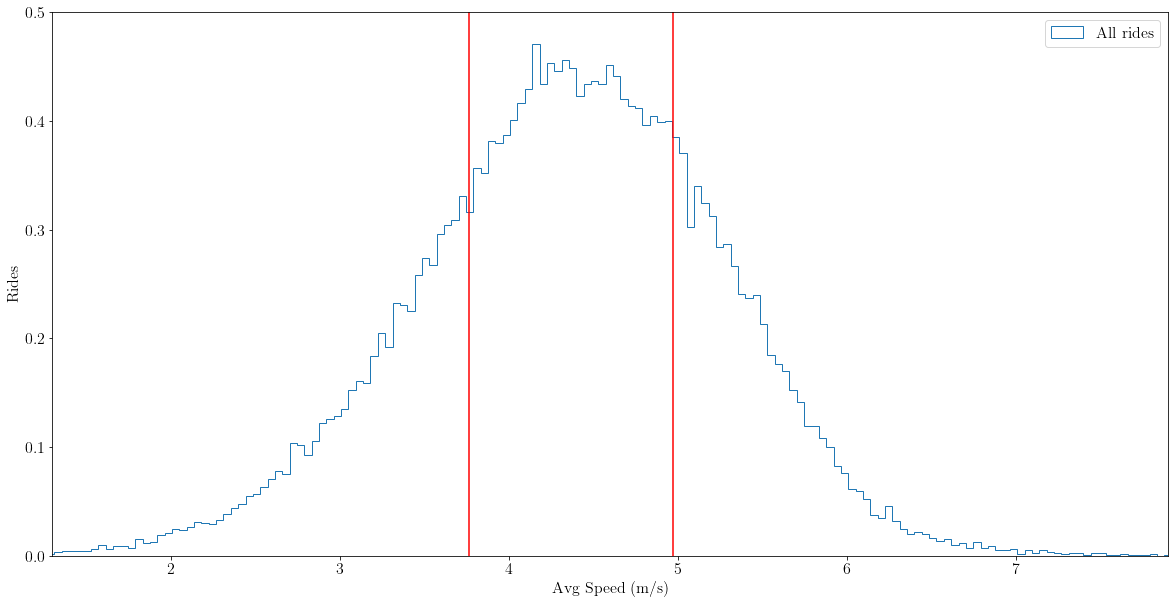

<Figure size 432x288 with 0 Axes>

In [18]:
# Avg speed of all rides in m/s
fig = plt.figure(figsize=[20, 10])

ax = plt.axes()
# ax.grid()
# ax.xaxis.set_major_locator(ticker.LinearLocator(numticks=30))
ax.set_ylabel('Rides')
ax.set_xlabel('Avg Speed (m/s)')
# plot_graph(pdf_avg_0['avg_speed'], "Slow rides (first 25%)", False, 400, False, 1.3, 7.9, 0, 500)
# plot_graph(pdf_avg_1['avg_speed'], "Medium rides (middle 50%)", False, 200, False, 1.3, 7.9, 0, 500)
# plot_graph(pdf_avg_2['avg_speed'], "Fast rides (last 25%)", False, 400, False, 1.3, 7.9, 0, 500)
plot_graph(pdf_avg_all['avg_speed'], "All rides", True, 200, True, 1.3, 7.9, 0, 0.5)

plt.legend()
plt.show()
plt.savefig("images/velo_avg_all_rides_new.png", dpi=300, bbox_inches='tight')


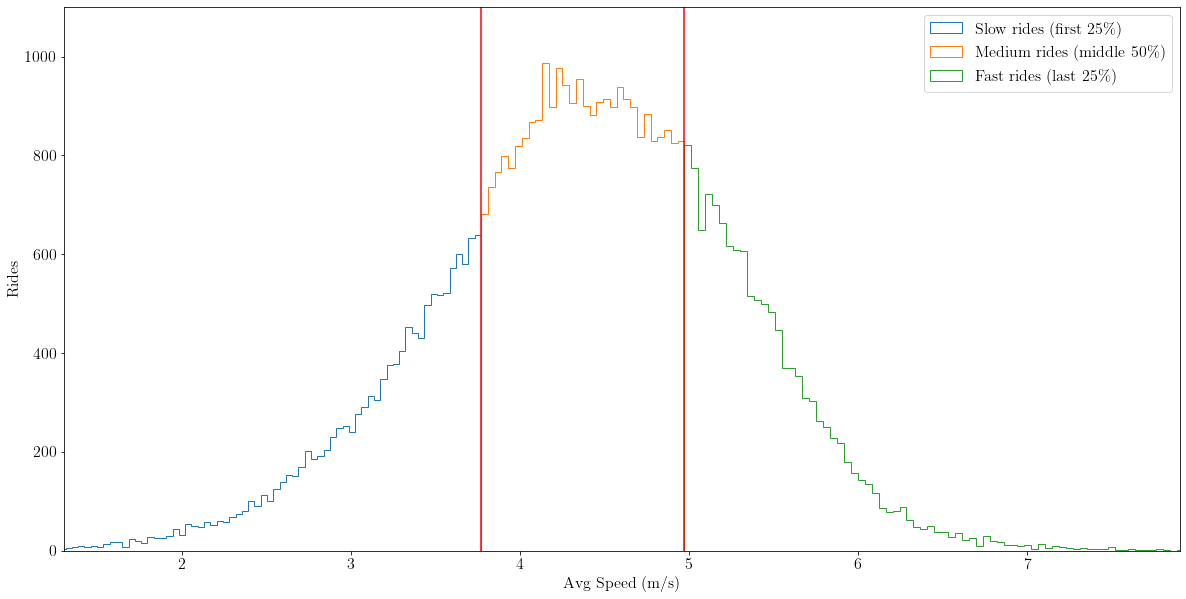

<Figure size 432x288 with 0 Axes>

In [19]:
# Avg speed of all groups in m/s
fig = plt.figure(figsize=[20, 10])

ax = plt.axes()
# ax.grid()
# ax.xaxis.set_major_locator(ticker.LinearLocator(numticks=30))
ax.set_ylabel('Rides')
ax.set_xlabel('Avg Speed (m/s)')
plot_graph(pdf_avg_0['avg_speed'], "Slow rides (first 25\%)", False, 80, False, 1.3, 7.9, 0, 1100)
plot_graph(pdf_avg_1['avg_speed'], "Medium rides (middle 50\%)", False, 30, False, 1.3, 7.9, 0, 1100)
plot_graph(pdf_avg_2['avg_speed'], "Fast rides (last 25\%)", False, 110, False, 1.3, 7.9, 0, 1100)
plt.vlines([pdf_avg_all['avg_speed'].iloc[int(0.25 * len(pdf_avg_all['avg_speed']))], pdf_avg_all['avg_speed'].iloc[int(0.75 * len(pdf_avg_all['avg_speed']))]], 0, 10000, colors='r')

plt.legend()
plt.show()
plt.savefig("images/velo_avg_groups_new.png", dpi=300, bbox_inches='tight')

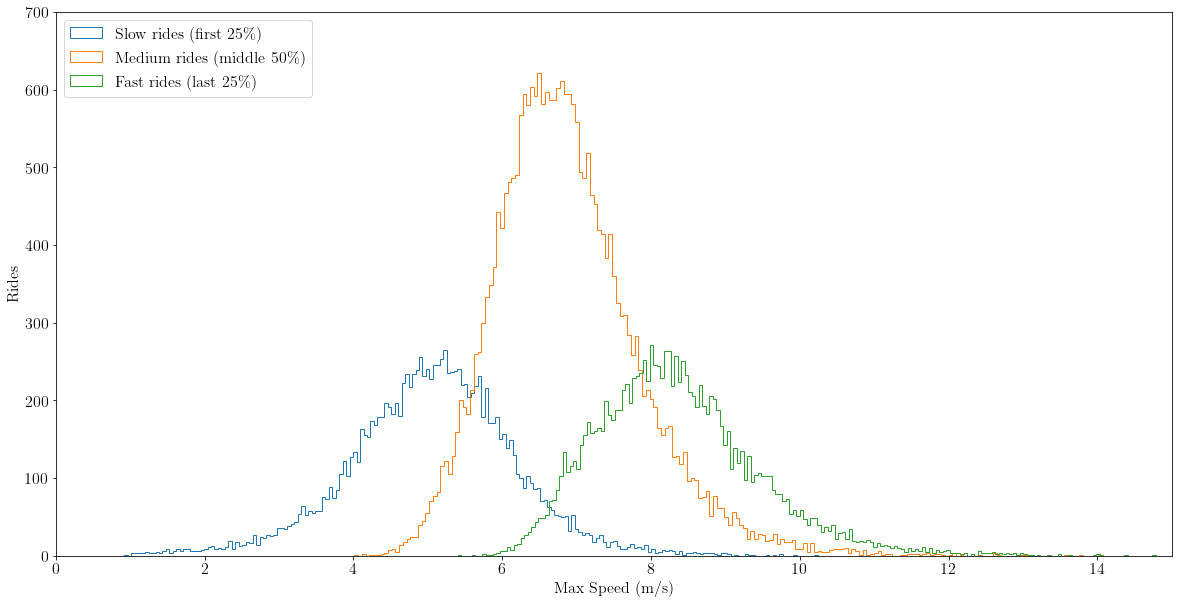

<Figure size 432x288 with 0 Axes>

In [20]:
# Max speed of all groups in m/s
fig = plt.figure(figsize=[20, 10])

ax = plt.axes()
# ax.grid()
# ax.xaxis.set_major_locator(ticker.LinearLocator(numticks=30))
ax.set_ylabel('Rides')
ax.set_xlabel('Max Speed (m/s)')

#plot_graph(pdf_avg_0['avg_speed'], "Group 0", False)
plot_graph(pdf_max_0['max_speed'], "Slow rides (first 25\%)", False, 200, False, 0, 15, 0, 700)

#plot_graph(pdf_avg_1['avg_speed'], "Group 1", False)
plot_graph(pdf_max_1['max_speed'], "Medium rides (middle 50\%)", False, 200, False, 0, 15, 0, 700)

#plot_graph(pdf_avg_2['avg_speed'], "Group 2", False)
plot_graph(pdf_max_2['max_speed'], "Fast rides (last 25\%)", False, 200, False, 0, 15, 0, 700)

plt.legend()
plt.show()
plt.savefig("images/velo_max_groups_new.png", dpi=300, bbox_inches='tight')

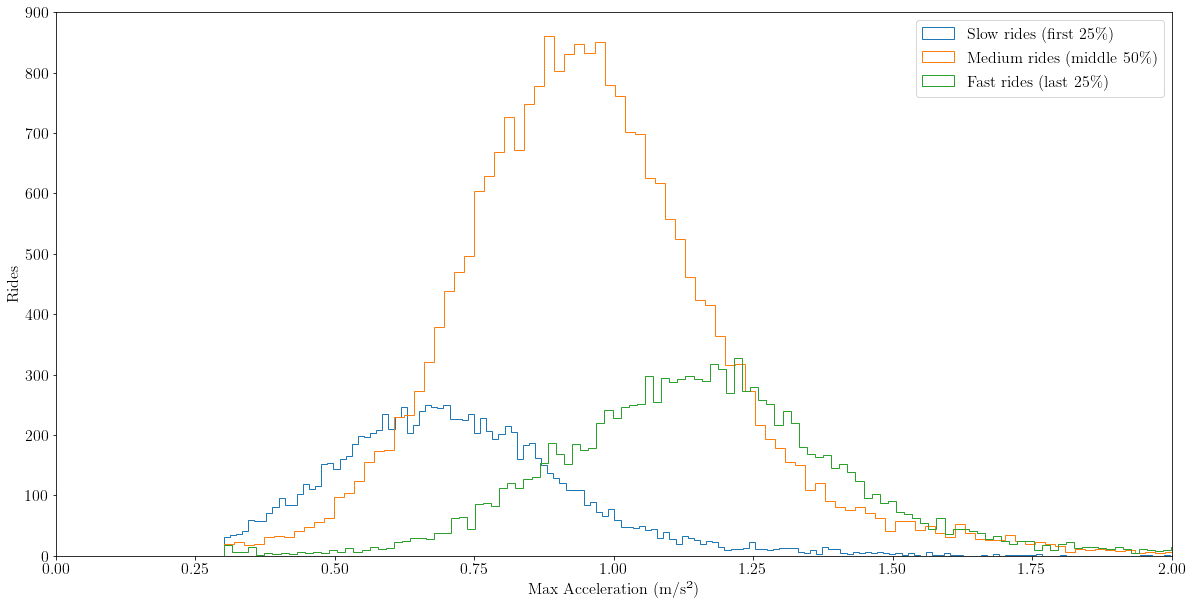

<Figure size 432x288 with 0 Axes>

In [21]:
# Max acceleration of all groups in m/s
fig = plt.figure(figsize=[20, 10])

ax = plt.axes()
# ax.grid()
# ax.xaxis.set_major_locator(ticker.LinearLocator(numticks=30))
ax.set_ylabel('Rides')
ax.set_xlabel('Max Acceleration (m/s²)')
plt.xlim(0, 2)

#plot_graph(pdf_avg_0['avg_speed'], "Group 0", False)
plot_graph(pdf_acc_0['max_accel'], "Slow rides (first 25\%)", False, 200, False, 0, 2, 0, 900)

#plot_graph(pdf_avg_1['avg_speed'], "Group 1", False)
plot_graph(pdf_acc_1['max_accel'], "Medium rides (middle 50\%)", False, 200, False, 0, 2, 0, 900)

#plot_graph(pdf_avg_2['avg_speed'], "Group 2", False)
plot_graph(pdf_acc_2['max_accel'], "Fast rides (last 25\%)", False, 200, False, 0, 2, 0, 900)

plt.legend()
plt.show()
plt.savefig("images/acc_max_groups_new.png", dpi=300, bbox_inches='tight')

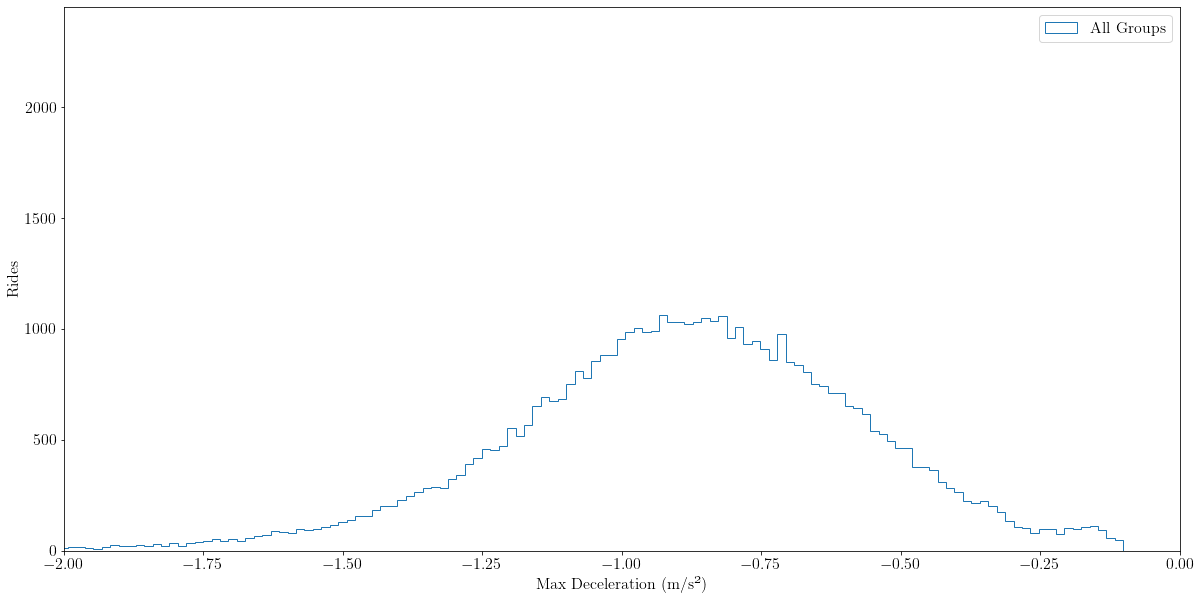

In [11]:
# Max deceleration of all groups combined in m/s
fig = plt.figure(figsize=[20, 10])

ax = plt.axes()
# ax.grid()
# ax.xaxis.set_major_locator(ticker.LinearLocator(numticks=30))
ax.set_ylabel('Rides')
ax.set_xlabel('Max Deceleration (m/s²)')
# plt.xlim(-1.2, 0)

#plot_graph(pdf_avg_0['avg_speed'], "Group 0", False)
plot_graph(pdf_dec_all['max_decel'], "All Groups", False, 200, False, -2, 0, 0, 2450)

#plot_graph(pdf_avg_1['avg_speed'], "Group 1", False)
#plot_graph(pdf_acc_1['max_accel'], "Group 1", False)

#plot_graph(pdf_avg_2['avg_speed'], "Group 2", False)
#plot_graph(pdf_acc_2['max_accel'], "Group 2", False)

plt.legend()
plt.show()

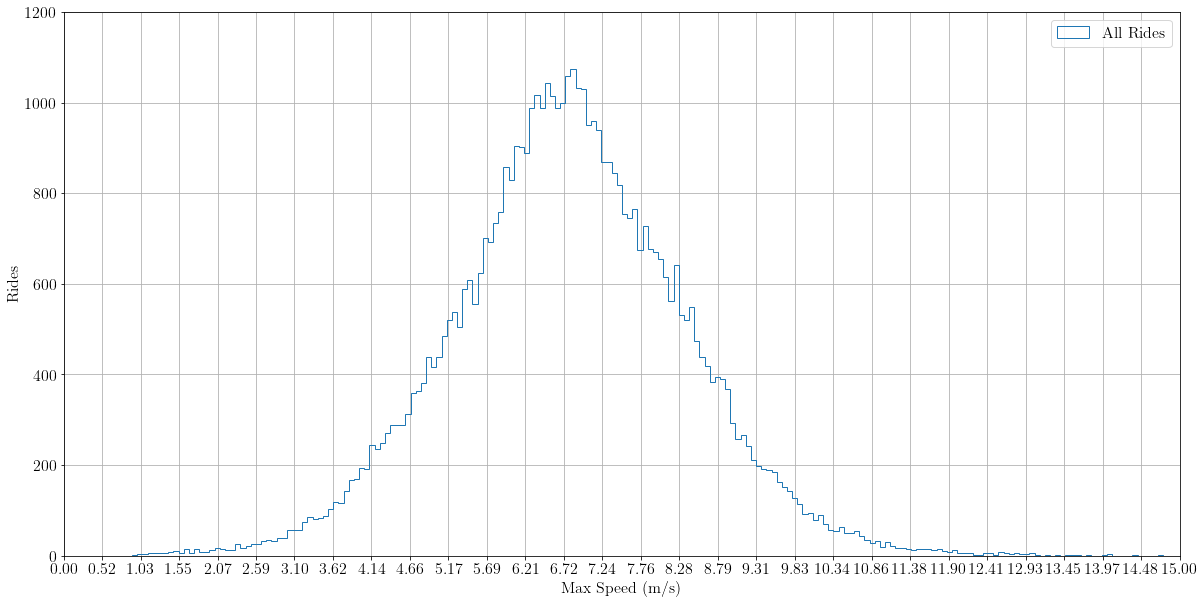

In [12]:
# Max speed of all rides in m/s
fig = plt.figure(figsize=[20, 10])

ax = plt.axes()
ax.grid()
ax.xaxis.set_major_locator(ticker.LinearLocator(numticks=30))
ax.set_ylabel('Rides')
ax.set_xlabel('Max Speed (m/s)')

#plot_graph(pdf_avg_0['avg_speed'], "Group 0", False)
plot_graph(pdf_all['max_speed'], "All Rides", False, 200, False, 0, 15, 0, 1200)

plt.legend()
plt.show()

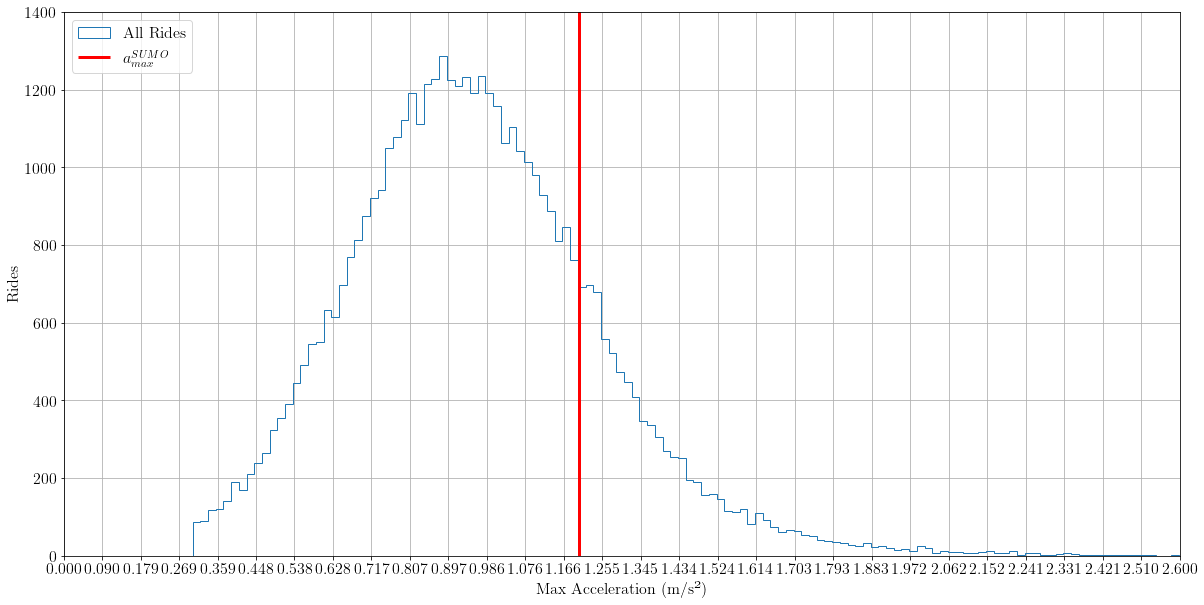

In [13]:
# Max acceleration of all rides in m/s
fig = plt.figure(figsize=[20, 10])

ax = plt.axes()
ax.grid()
ax.xaxis.set_major_locator(ticker.LinearLocator(numticks=30))
ax.set_ylabel('Rides')
ax.set_xlabel('Max Acceleration (m/s²)')

#plot_graph(pdf_avg_0['avg_speed'], "Group 0", False)
plot_graph(pdf_acc_all['max_accel'], "All Rides", False, 200, False, 0, 2.6, 0, 1400)
plt.vlines(1.2, 0, 10000, colors='r', linewidth=3, label=r'$a_{max}^{SUMO}$')

plt.legend()
plt.show()

In [ ]:
# Find the best distribution for group 0 v_max

list_of_dists_for_v_max = ['beta', 'betaprime', 'bradford', 'burr', 'burr12', 'cauchy', 'chi', 'chi2', 'cosine', 'dgamma', 'dweibull', 'erlang', 'expon', 'exponnorm', 'exponweib', 'exponpow', 'f', 'fatiguelife', 'fisk', 'foldcauchy', 'foldnorm', 'frechet_r', 'frechet_l', 'genlogistic', 'genpareto', 'gennorm', 'genexpon', 'genextreme', 'gausshyper', 'gamma', 'gengamma', 'genhalflogistic', 'gilbrat', 'gompertz', 'gumbel_r', 'gumbel_l', 'halfcauchy', 'halflogistic', 'halfnorm', 'halfgennorm', 'hypsecant', 'invgamma', 'invgauss', 'invweibull', 'johnsonsb', 'johnsonsu', 'kstwobign', 'laplace', 'levy', 'levy_l', 'logistic', 'loggamma', 'loglaplace', 'lognorm', 'lomax', 'maxwell', 'mielke', 'nakagami', 'ncx2', 'ncf', 'nct', 'norm', 'pareto', 'pearson3', 'powerlaw', 'powerlognorm', 'powernorm', 'rdist', 'reciprocal', 'rayleigh', 'rice', 'recipinvgauss', 'semicircular', 't', 'triang', 'truncexpon', 'truncnorm', 'tukeylambda', 'uniform', 'vonmises', 'vonmises_line', 'wald', 'weibull_min', 'weibull_max']

results=[]
for i in list_of_dists_for_v_max:
    try:
        dist = getattr(scipy.stats, i)
        param = dist.fit(pdf_max_0['max_speed'])
        a0 = scipy.stats.kstest(pdf_max_0['max_speed'], i, args=param)
        # print("{}: statistic={}, pvalue={}".format(i, a[0], a[1]))
        results.append((i, a0[0], a0[1], param))
    except ValueError as e:
        print("      error type {} for {}".format(e,i))
        continue

results.sort(key=lambda x:float(x[2]), reverse=True)
for j in results:
    print("{}: statistic={}, pvalue={}, param={}".format(j[0], j[1], j[2], j[3]))

In [ ]:
# Find the best distribution for group 1 v_max

results=[]
for i in list_of_dists_for_v_max:
    try:
        dist = getattr(scipy.stats, i)
        param = dist.fit(pdf_max_1['max_speed'])
        a0 = scipy.stats.kstest(pdf_max_1['max_speed'], i, args=param)
        # print("{}: statistic={}, pvalue={}".format(i, a[0], a[1]))
        results.append((i, a0[0], a0[1], param))
    except ValueError as e:
        print("      error type {} for {}".format(e,i))
        continue

results.sort(key=lambda x:float(x[2]), reverse=True)
# for j in results:
for j in range (0,2):
    print("{}: statistic={}, pvalue={}, param={}".format(results[j][0], results[j][1], results[j][2], results[j][3]))

In [ ]:
# Find the best distribution for group 2 v_max

results=[]
for i in list_of_dists_for_v_max:
    try:
        dist = getattr(scipy.stats, i)
        param = dist.fit(pdf_max_2['max_speed'])
        a0 = scipy.stats.kstest(pdf_max_2['max_speed'], i, args=param)
        # print("{}: statistic={}, pvalue={}".format(i, a[0], a[1]))
        results.append((i, a0[0], a0[1], param))
    except ValueError as e:
        print("      error type {} for {}".format(e,i))
        continue

results.sort(key=lambda x:float(x[2]), reverse=True)
for j in range (0,2):
    print("{}: statistic={}, pvalue={}, param={}".format(results[j][0], results[j][1], results[j][2], results[j][3]))
# for j in results:
#     print("{}: statistic={}, pvalue={}, param={}".format(j[0], j[1], j[2], j[3]))

In [ ]:
# Find the best distribution for group 0 a_max

list_of_dists_for_a_max = ['alpha', 'anglit', 'arcsine', 'beta', 'betaprime', 'bradford', 'burr', 'burr12', 'cauchy', 'chi', 'chi2', 'cosine', 'dgamma', 'dweibull', 'erlang', 'expon', 'exponnorm', 'exponweib', 'exponpow', 'f', 'fatiguelife', 'fisk', 'foldcauchy', 'foldnorm', 'frechet_r', 'frechet_l', 'genlogistic', 'genpareto', 'gennorm', 'genexpon', 'genextreme', 'gausshyper', 'gamma', 'gengamma', 'genhalflogistic', 'gilbrat', 'gompertz', 'gumbel_r', 'gumbel_l', 'halfcauchy', 'halflogistic', 'halfnorm', 'halfgennorm', 'hypsecant', 'invgamma', 'invgauss', 'invweibull', 'johnsonsb', 'johnsonsu', 'kstwobign', 'laplace', 'levy', 'levy_l', 'logistic', 'loggamma', 'loglaplace', 'lognorm', 'lomax', 'maxwell', 'mielke', 'nakagami', 'ncx2', 'ncf', 'nct', 'norm', 'pareto', 'pearson3', 'powerlaw', 'powerlognorm', 'powernorm', 'rdist', 'reciprocal', 'rayleigh', 'rice', 'recipinvgauss', 'semicircular', 't', 'triang', 'truncexpon', 'truncnorm', 'tukeylambda', 'uniform', 'vonmises', 'vonmises_line', 'wald', 'weibull_min', 'weibull_max']
results=[]
for i in list_of_dists_for_a_max:
    try:
        dist = getattr(scipy.stats, i)
        param = dist.fit(pdf_acc_0['max_accel'])
        a0 = scipy.stats.kstest(pdf_acc_0['max_accel'], i, args=param)
        # print("{}: statistic={}, pvalue={}".format(i, a[0], a[1]))
        results.append((i, a0[0], a0[1], param))
    except ValueError as e:
        print("      error type {} for {}".format(e,i))
        continue

results.sort(key=lambda x:float(x[2]), reverse=True)
for j in range (0,2):
    print("{}: statistic={}, pvalue={}, param={}".format(results[j][0], results[j][1], results[j][2], results[j][3]))
# for j in results:
#     print("{}: statistic={}, pvalue={}, param={}".format(j[0], j[1], j[2], j[3]))

In [ ]:
# Find the best distribution for group 1 a_max

results=[]
for i in list_of_dists_for_a_max:
    try:
        dist = getattr(scipy.stats, i)
        param = dist.fit(pdf_acc_1['max_accel'])
        a0 = scipy.stats.kstest(pdf_acc_1['max_accel'], i, args=param)
        # print("{}: statistic={}, pvalue={}".format(i, a[0], a[1]))
        results.append((i, a0[0], a0[1], param))
    except ValueError as e:
        print("      error type {} for {}".format(e,i))
        continue

results.sort(key=lambda x:float(x[2]), reverse=True)
for j in range (0,2):
    print("{}: statistic={}, pvalue={}, param={}".format(results[j][0], results[j][1], results[j][2], results[j][3]))
# for j in results:
#     print("{}: statistic={}, pvalue={}, param={}".format(j[0], j[1], j[2], j[3]))

In [ ]:
# Find the best distribution for group 2 a_max
results=[]
for i in list_of_dists_for_a_max:
    try:
        dist = getattr(scipy.stats, i)
        param = dist.fit(pdf_acc_2['max_accel'])
        a0 = scipy.stats.kstest(pdf_acc_2['max_accel'], i, args=param)
        # print("{}: statistic={}, pvalue={}".format(i, a[0], a[1]))
        results.append((i, a0[0], a0[1], param))
    except ValueError as e:
        print("      error type {} for {}".format(e,i))
        continue

results.sort(key=lambda x:float(x[2]), reverse=True)
for j in range (0,2):
    print("{}: statistic={}, pvalue={}, param={}".format(results[j][0], results[j][1], results[j][2], results[j][3]))
# for j in results:
#     print("{}: statistic={}, pvalue={}, param={}".format(j[0], j[1], j[2], j[3]))

In [ ]:
# Find the best distribution for group 0 d_max
list_of_dists_for_d_max = ['powernorm','norm','exponnorm','beta','betaprime','bradford','burr','burr12','cauchy','chi','chi2','cosine','dgamma','dweibull','erlang','expon','exponnorm','exponweib','exponpow','f','fatiguelife','fisk','foldcauchy','foldnorm','frechet_r','frechet_l','genlogistic','genpareto','gennorm','genexpon','genextreme','gausshyper','gamma','gengamma','genhalflogistic','gilbrat','gompertz','gumbel_r','gumbel_l','halfcauchy','halflogistic','halfnorm','halfgennorm','hypsecant','invgamma','invgauss','invweibull','johnsonsb','johnsonsu','kstwobign','laplace','levy','levy_l','logistic','loggamma','loglaplace','lognorm','lomax','maxwell','mielke','nakagami','ncx2','ncf','nct','norm','pareto','pearson3','powerlaw','powerlognorm','powernorm','rdist','reciprocal','rayleigh','rice','recipinvgauss','semicircular','t','triang','truncexpon','truncnorm','tukeylambda','uniform','vonmises','vonmises_line','wald','weibull_min','weibull_max']
results=[]

for i in list_of_dists_for_d_max:
    try:
        dist = getattr(scipy.stats, i)
        param = dist.fit(pdf_dec_0['max_decel'])
        a0 = scipy.stats.kstest(pdf_dec_0['max_decel'], i, args=param)
        # print("{}: statistic={}, pvalue={}".format(i, a[0], a[1]))
        results.append((i, a0[0], a0[1], param))
    except ValueError as e:
        print("      error type {} for {}".format(e,i))
        continue

results.sort(key=lambda x:float(x[2]), reverse=True)
for j in range (0,2):
    print("{}: statistic={}, pvalue={}, param={}".format(results[j][0], results[j][1], results[j][2], results[j][3]))
# for j in results:
#     print("{}: statistic={}, pvalue={}, param={}".format(j[0], j[1], j[2], j[3]))

In [ ]:
# Find the best distribution for group 1 d_max
results=[]
for i in list_of_dists_for_d_max:
    try:
        dist = getattr(scipy.stats, i)
        param = dist.fit(pdf_dec_1['max_decel'])
        a0 = scipy.stats.kstest(pdf_dec_1['max_decel'], i, args=param)
        # print("{}: statistic={}, pvalue={}".format(i, a[0], a[1]))
        results.append((i, a0[0], a0[1], param))
    except ValueError as e:
        print("      error type {} for {}".format(e,i))
        continue

results.sort(key=lambda x:float(x[2]), reverse=True)
for j in range (0,2):
    print("{}: statistic={}, pvalue={}, param={}".format(results[j][0], results[j][1], results[j][2], results[j][3]))
# for j in results:
#     print("{}: statistic={}, pvalue={}, param={}".format(j[0], j[1], j[2], j[3]))

In [ ]:
# Find the best distribution for group 2 d_max
results=[]
for i in list_of_dists_for_d_max:
    try:
        dist = getattr(scipy.stats, i)
        param = dist.fit(pdf_dec_2['max_decel'])
        a0 = scipy.stats.kstest(pdf_dec_2['max_decel'], i, args=param)
        # print("{}: statistic={}, pvalue={}".format(i, a[0], a[1]))
        results.append((i, a0[0], a0[1], param))
    except ValueError as e:
        print("      error type {} for {}".format(e,i))
        continue

results.sort(key=lambda x:float(x[2]), reverse=True)
for j in range (0,2):
    print("{}: statistic={}, pvalue={}, param={}".format(results[j][0], results[j][1], results[j][2], results[j][3]))
# for j in results:
#     print("{}: statistic={}, pvalue={}, param={}".format(j[0], j[1], j[2], j[3]))

In [ ]:
# plots for v_max

plt.figure(figsize=(10,8))
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 16})
rc('text', usetex=True)
plt.hist(pdf_max_0['max_speed'], bins=65, density=True, label=r'$^{s}v_{max}^{SimRa}$', alpha=0.3)
plt.hist(pdf_max_1['max_speed'], bins=65, density=True, label=r'$^{m}v_{max}^{SimRa}$', alpha=0.3)
plt.hist(pdf_max_2['max_speed'], bins=65, density=True, label=r'$^{f}v_{max}^{SimRa}$', alpha=0.3)

# plt.hist(pdf_max_0['max_speed'], bins=65, density=True, label=r'$^{s}v_{max}^{SimRa}$', histtype='step')
# plt.hist(pdf_max_1['max_speed'], bins=65, density=True, label=r'$^{m}v_{max}^{SimRa}$', histtype='step')
# plt.hist(pdf_max_2['max_speed'], bins=65, density=True, label=r'$^{f}v_{max}^{SimRa}$', histtype='step')

# johnsonsu: statistic=0.004896746744468827, pvalue=0.9037362281423775, param=(0.17177979659713563, 2.0052692655228785, 5.244025875304043, 1.9461729586112435)
a0, b0, c0, d0 = scipy.stats.johnsonsu.fit(pdf_max_0['max_speed']) # 0 v_max -> johnsonsu (4 params)
# exponnorm: statistic=0.003203900633740875, pvalue=0.9463245338435855, param=(1.151847776400146, 6.125155871008447, 0.6368067788368326)
a1, b1, c1 = scipy.stats.exponnorm.fit(pdf_max_1['max_speed']) # 1 v_max -> exponnorm (3 params)
# nct: statistic=0.012005331014221077, pvalue=0.04264766592061031, param=(34.71300201628809, 31.8573451917904, -0.11087431634014067, 0.25931067417519293)
a2, b2, c2, d2 = scipy.stats.nct.fit(pdf_max_2['max_speed']) # 2 v_max -> burr12 (4 params)
x = np.linspace(0, 16, 1000)
y0 = scipy.stats.johnsonsu.pdf(x, a0, b0, c0, d0)
y1 = scipy.stats.exponnorm.pdf(x, a1, b1, c1)
y2 = scipy.stats.nct.pdf(x, a2, b2, c2, d2)
# Johnson SU
plt.plot(x, y0, linewidth=3, label='JSU(' + r'$^{s}v_{max}; \Phi^*$' + ')')
# exponentially modified Gaussian distribution (EMG)
plt.plot(x, y1, linewidth=3, label='EMG(' + r'$^{m}v_{max}; \Phi^*$' + ')')
# Burr12
plt.plot(x, y2, linewidth=3, label='NCT(' + r'$^{f}v_{max}; \Phi^*$' + ')')
plt.xlabel(r'$v_{max}$ in m/s')
plt.ylabel('Relative frequency')
plt.vlines(5.56, 0, 4, colors='r', linewidth=3, label=r'$v_{max}^{SUMO}$')
plt.xlim(1, 15)
plt.ylim(0, 0.5)

plt.legend()

print("0:{}{}{}{}".format(a0,b0,c0,d0))
print("1:{}{}{}".format(a1,b1,c1))
print("2:{}{}{}{}".format(a2,b2,c2,d2))

# print(scipy.stats.nct.cdf(5.56, a0, b0, loc0, scale0))
# print(scipy.stats.nct.cdf(25 / 3.6, a0, b0, loc0, scale0)) #
#
# print(scipy.stats.kstest(pdf_max_0['max_speed'], 'nct', args=(a0, b0, loc0, scale0)))
# print(a0, b0, loc0, scale0)
# print(scipy.stats.nct.ppf(0.05, a0, b0, loc0, scale0))
# print(scipy.stats.nct.ppf(0.95, a0, b0, loc0, scale0))
plt.savefig("images/v_max_groups_dist_rel_new.png", dpi=300, bbox_inches='tight')

In [ ]:
# plots for a_max

plt.figure(figsize=(10,8))
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 16})
rc('text', usetex=True)
plt.hist(pdf_acc_0['max_accel'], bins=65, density=True, label=r'$^{s}a_{max}^{SimRa}$', alpha=0.3)
plt.hist(pdf_acc_1['max_accel'], bins=65, density=True, label=r'$^{m}a_{max}^{SimRa}$', alpha=0.3)
plt.hist(pdf_acc_2['max_accel'], bins=65, density=True, label=r'$^{f}a_{max}^{SimRa}$', alpha=0.3)

# burr: statistic=0.006872481395881702, pvalue=0.670274585635346, param=(5.555017473724288, 0.3472125253420125, 0.2890578421354373, 0.5730493867811146)
a0, b0, c0, d0 = scipy.stats.burr.fit(pdf_acc_0['max_accel']) # 0 a_max -> burr (4 params)
# mielke: statistic=0.0043266880722089285, pvalue=0.7416766368222676, param=(5.622196601013915, 7.835472193275419, 0.04589095584641944, 0.953196030010006)
a1, b1, c1, d1 = scipy.stats.mielke.fit(pdf_acc_1['max_accel']) # 1 a_max -> mielke (4 params)
# burr: statistic=0.007993902948066123, pvalue=0.4080951882253737, param=(9.336613794008368, 0.6581541735079106, -0.025745072542825417, 1.2570925123823815)
a2, b2, c2, d2 = scipy.stats.burr.fit(pdf_acc_2['max_accel']) # 2 a_max -> johnsonsu (4 params)
x = np.linspace(0, 16, 1000)
# Burr Type III
y0 = scipy.stats.burr.pdf(x, a0, b0, c0, d0)
# Mielke Beta-Kappa distribution
y1 = scipy.stats.mielke.pdf(x, a1, b1, c1, d1)
# Burr Type III
y2 = scipy.stats.burr.pdf(x, a2, b2, c2, d2)
# Burr Type III
plt.plot(x, y0, linewidth=3, label='Burr3(' + r'$^{s}a_{max}; \Phi^*$' + ')')
# Mielke Beta-Kappa
plt.plot(x, y1, linewidth=3, label='M' + r'$\beta\kappa$' + '(' + r'$^{m}a_{max}; \Phi^*$' + ')')
# Burr Type III
plt.plot(x, y2, linewidth=3, label='Burr3(' + r'$^{f}a_{max}; \Phi^*$' + ')')
plt.xlabel(r'$a_{max}$ in m/s²')
plt.ylabel('Relative frequency')
plt.vlines(1.2, 0, 4, colors='r', linewidth=3, label=r'$v_{max}^{SUMO}$')
plt.xlim(0, 2)
plt.ylim(0, 2.1)

plt.legend()

print("0:{}{}{}{}".format(a0,b0,c0,d0))
print("1:{}{}{}".format(a1,b1,c1))
print("2:{}{}{}{}".format(a2,b2,c2,d2))

# print(scipy.stats.nct.cdf(5.56, a0, b0, loc0, scale0))
# print(scipy.stats.nct.cdf(25 / 3.6, a0, b0, loc0, scale0)) #
#
# print(scipy.stats.kstest(pdf_max_0['max_speed'], 'nct', args=(a0, b0, loc0, scale0)))
# print(a0, b0, loc0, scale0)
# print(scipy.stats.nct.ppf(0.05, a0, b0, loc0, scale0))
# print(scipy.stats.nct.ppf(0.95, a0, b0, loc0, scale0))
plt.savefig("images/a_max_groups_dist_rel_new.png", dpi=300, bbox_inches='tight')

In [ ]:
# plots for d_max

plt.figure(figsize=(10,8))
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 16})
rc('text', usetex=True)
# plt.hist(pdf_dec_all['max_decel'], bins=65, density=True, label=r'$d_{max}^{SimRa}$', alpha=0.3)
plt.hist(pdf_dec_0['max_decel'][lambda x: x < 0], bins=65, density=True, label=r'$^{s}d_{max}^{SimRa}$', alpha=0.3)
plt.hist(pdf_dec_1['max_decel'][lambda x: x < 0], bins=65, density=True, label=r'$^{m}d_{max}^{SimRa}$', alpha=0.3)
plt.hist(pdf_dec_2['max_decel'][lambda x: x < 0], bins=65, density=True, label=r'$^{f}d_{max}^{SimRa}$', alpha=0.3)


# johnsonsu: statistic=0.01440739140031616, pvalue=0.009237818137087182, param=(1.4834543837587546, 2.8564313156019154, -0.3490495847362426, 0.5368055298655655)
a0, b0, c0, d0 = scipy.stats.johnsonsu.fit(pdf_dec_0['max_decel'][lambda x: x < 0]) # d_max -> johnsonsu (4 params)
# johnsonsu: statistic=0.008180491632507392, pvalue=0.06028441416708774, param=(0.211594026050701, 1.7372677398843126, -0.8419616780458262, 0.39319163181725114)
a1, b1, c1, d1 = scipy.stats.johnsonsu.fit(pdf_dec_1['max_decel'][lambda x: x < 0]) # d_max -> johnsonsu (4 params)
# t: statistic=0.007472741520479276, pvalue=0.46207533394741074, param=(4.743822607528365, -1.09865060264125, 0.24811680483557794)
a2, b2, c2 = scipy.stats.t.fit(pdf_dec_2['max_decel'][lambda x: x < 0]) # d_max -> t (3 params)

x = np.linspace(-2, 0, 1000)
y0 = scipy.stats.johnsonsu.pdf(x, a0, b0, c0, d0)
y1 = scipy.stats.johnsonsu.pdf(x, a1, b1, c1, d1)
y2 = scipy.stats.t.pdf(x, a2, b2, c2)
# Johnson SU
plt.plot(x, y0, linewidth=3, label='JSU(' + r'$^{s}d_{max}; \Phi^*$' + ')')
# Johnson SU
plt.plot(x, y1, linewidth=3, label='JSU(' + r'$^{m}d_{max}; \Phi^*$' + ')')
# Student's t-distribution (or simply the t-distribution)
plt.plot(x, y2, linewidth=3, label='T(' + r'$^{f}d_{max}; \Phi^*$' + ')')
plt.xlabel(r'$d_{max}$ in m/s²')
plt.ylabel('Relative frequency')
plt.vlines(-3, 0, 10, colors='r', linewidth=3, label=r'$v_{max}^{SUMO}$')
plt.xlim(-3.1, 0)
plt.ylim(0, 1.9)

plt.legend()

# print(scipy.stats.nct.cdf(5.56, a0, b0, loc0, scale0))
# print(scipy.stats.nct.cdf(25 / 3.6, a0, b0, loc0, scale0)) #
#
# print(scipy.stats.kstest(pdf_max_0['max_speed'], 'nct', args=(a0, b0, loc0, scale0)))
# print(a0, b0, loc0, scale0)
# print(scipy.stats.nct.ppf(0.05, a0, b0, loc0, scale0))
# print(scipy.stats.nct.ppf(0.95, a0, b0, loc0, scale0))
plt.savefig("images/d_max_groups_dist_rel_new.png", dpi=300, bbox_inches='tight')

In [ ]:
# Find the best distribution for all rides v_max

list_of_dists_for_v_max = ['beta', 'betaprime', 'bradford', 'burr', 'burr12', 'cauchy', 'chi', 'chi2', 'cosine', 'dgamma', 'dweibull', 'erlang', 'expon', 'exponnorm', 'exponweib', 'exponpow', 'f', 'fatiguelife', 'fisk', 'foldcauchy', 'foldnorm', 'frechet_r', 'frechet_l', 'genlogistic', 'genpareto', 'gennorm', 'genexpon', 'genextreme', 'gausshyper', 'gamma', 'gengamma', 'genhalflogistic', 'gilbrat', 'gompertz', 'gumbel_r', 'gumbel_l', 'halfcauchy', 'halflogistic', 'halfnorm', 'halfgennorm', 'hypsecant', 'invgamma', 'invgauss', 'invweibull', 'johnsonsb', 'johnsonsu', 'kstwobign', 'laplace', 'levy', 'levy_l', 'logistic', 'loggamma', 'loglaplace', 'lognorm', 'lomax', 'maxwell', 'mielke', 'nakagami', 'ncx2', 'ncf', 'nct', 'norm', 'pareto', 'pearson3', 'powerlaw', 'powerlognorm', 'powernorm', 'rdist', 'reciprocal', 'rayleigh', 'rice', 'recipinvgauss', 'semicircular', 't', 'triang', 'truncexpon', 'truncnorm', 'tukeylambda', 'uniform', 'vonmises', 'vonmises_line', 'wald', 'weibull_min', 'weibull_max']

results=[]
for i in list_of_dists_for_v_max:
    try:
        dist = getattr(scipy.stats, i)
        param = dist.fit(pdf_max_all['max_speed'])
        a0 = scipy.stats.kstest(pdf_max_all['max_speed'], i, args=param)
        # print("{}: statistic={}, pvalue={}".format(i, a[0], a[1]))
        results.append((i, a0[0], a0[1], param))
    except ValueError as e:
        print("      error type {} for {}".format(e,i))
        continue

results.sort(key=lambda x:float(x[2]), reverse=True)
for j in range (0,2):
    print("{}: statistic={}, pvalue={}, param={}".format(results[j][0], results[j][1], results[j][2], results[j][3]))
# for j in results:
#     print("{}: statistic={}, pvalue={}, param={}".format(j[0], j[1], j[2], j[3]))

In [ ]:
 # Find the best distribution for all rides a_max

list_of_dists_for_a_max = ['alpha', 'anglit', 'arcsine', 'beta', 'betaprime', 'bradford', 'burr', 'burr12', 'cauchy', 'chi', 'chi2', 'cosine', 'dgamma', 'dweibull', 'erlang', 'expon', 'exponnorm', 'exponweib', 'exponpow', 'f', 'fatiguelife', 'fisk', 'foldcauchy', 'foldnorm', 'frechet_r', 'frechet_l', 'genlogistic', 'genpareto', 'gennorm', 'genexpon', 'genextreme', 'gausshyper', 'gamma', 'gengamma', 'genhalflogistic', 'gilbrat', 'gompertz', 'gumbel_r', 'gumbel_l', 'halfcauchy', 'halflogistic', 'halfnorm', 'halfgennorm', 'hypsecant', 'invgamma', 'invgauss', 'invweibull', 'johnsonsb', 'johnsonsu', 'kstwobign', 'laplace', 'levy', 'levy_l', 'logistic', 'loggamma', 'loglaplace', 'lognorm', 'lomax', 'maxwell', 'mielke', 'nakagami', 'ncx2', 'ncf', 'nct', 'norm', 'pareto', 'pearson3', 'powerlaw', 'powerlognorm', 'powernorm', 'rdist', 'reciprocal', 'rayleigh', 'rice', 'recipinvgauss', 'semicircular', 't', 'triang', 'truncexpon', 'truncnorm', 'tukeylambda', 'uniform', 'vonmises', 'vonmises_line', 'wald', 'weibull_min', 'weibull_max']
results=[]
for i in list_of_dists_for_a_max:
    try:
        dist = getattr(scipy.stats, i)
        param = dist.fit(pdf_acc_all['max_accel'])
        a0 = scipy.stats.kstest(pdf_acc_all['max_accel'], i, args=param)
        # print("{}: statistic={}, pvalue={}".format(i, a[0], a[1]))
        results.append((i, a0[0], a0[1], param))
    except ValueError as e:
        print("      error type {} for {}".format(e,i))
        continue

results.sort(key=lambda x:float(x[2]), reverse=True)
for j in range (0,2):
    print("{}: statistic={}, pvalue={}, param={}".format(results[j][0], results[j][1], results[j][2], results[j][3]))
# for j in results:
#     print("{}: statistic={}, pvalue={}, param={}".format(j[0], j[1], j[2], j[3]))

In [ ]:
# Find the best distribution for all rides d_max
list_of_dists_for_d_max = ['powernorm','norm','exponnorm','beta','betaprime','bradford','burr','burr12','cauchy','chi','chi2','cosine','dgamma','dweibull','erlang','expon','exponnorm','exponweib','exponpow','f','fatiguelife','fisk','foldcauchy','foldnorm','frechet_r','frechet_l','genlogistic','genpareto','gennorm','genexpon','genextreme','gausshyper','gamma','gengamma','genhalflogistic','gilbrat','gompertz','gumbel_r','gumbel_l','halfcauchy','halflogistic','halfnorm','halfgennorm','hypsecant','invgamma','invgauss','invweibull','johnsonsb','johnsonsu','kstwobign','laplace','levy','levy_l','logistic','loggamma','loglaplace','lognorm','lomax','maxwell','mielke','nakagami','ncx2','ncf','nct','norm','pareto','pearson3','powerlaw','powerlognorm','powernorm','rdist','reciprocal','rayleigh','rice','recipinvgauss','semicircular','t','triang','truncexpon','truncnorm','tukeylambda','uniform','vonmises','vonmises_line','wald','weibull_min','weibull_max']
results=[]

for i in list_of_dists_for_d_max:
    try:
        dist = getattr(scipy.stats, i)
        param = dist.fit(pdf_dec_all['max_decel'])
        a0 = scipy.stats.kstest(pdf_dec_all['max_decel'], i, args=param)
        # print("{}: statistic={}, pvalue={}".format(i, a[0], a[1]))
        results.append((i, a0[0], a0[1], param))
    except ValueError as e:
        print("      error type {} for {}".format(e,i))
        continue

results.sort(key=lambda x:float(x[2]), reverse=True)
for j in range (0,2):
    print("{}: statistic={}, pvalue={}, param={}".format(results[j][0], results[j][1], results[j][2], results[j][3]))
# for j in results:
#     print("{}: statistic={}, pvalue={}, param={}".format(j[0], j[1], j[2], j[3]))

In [ ]:
# plot for all rides a_max

plt.figure(figsize=(10,8))
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 16})
rc('text', usetex=True)
plt.hist(pdf_acc_all['max_accel'], bins=65, density=True, label=r'$a_{max}^{SimRa}$', alpha=0.3)
# burr12: statistic=0.006628657832739471, pvalue=0.02899814282896107, param=(3.7084928118467992, 2.8837466199346977, 0.14944903718235975, 1.1162959144580862)
a0, b0, c0, d0 = scipy.stats.burr12.fit(pdf_acc_all['max_accel']) # 0 v_max -> burr12 (4 params)
x = np.linspace(0, 16, 1000)
y0 = scipy.stats.burr12.pdf(x, a0, b0, c0, d0)
# Burr 12
plt.plot(x, y0, linewidth=3, label='Burr12(' + r'$a_{max}; \Phi^*$' + ')')
plt.xlabel(r'$a_{max}$ in m/s')
plt.ylabel('Relative frequency')
plt.vlines(1.2, 0, 4, colors='r', linewidth=3, label=r'$a_{max}^{SUMO}$')
plt.xlim(0, 2)
plt.ylim(0, 1.55)

plt.legend()

# print(scipy.stats.nct.cdf(5.56, a0, b0, loc0, scale0))
# print(scipy.stats.nct.cdf(25 / 3.6, a0, b0, loc0, scale0)) #
#
# print(scipy.stats.kstest(pdf_max_0['max_speed'], 'nct', args=(a0, b0, loc0, scale0)))
# print(a0, b0, loc0, scale0)
# print(scipy.stats.nct.ppf(0.05, a0, b0, loc0, scale0))
# print(scipy.stats.nct.ppf(0.95, a0, b0, loc0, scale0))
plt.savefig("images/a_max_all_dist_rel_new.png", dpi=300, bbox_inches='tight')

In [ ]:
# plot for all rides v_max

plt.figure(figsize=(10,8))
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 16})
rc('text', usetex=True)
plt.hist(pdf_max_all['max_speed'], bins=65, density=True, label=r'$v_{max}^{SimRa}$', alpha=0.3)
# gennorm: statistic=0.005261780945291061, pvalue=0.10375834745304324, param=(1.6418252086391243, 6.770793122539128, 1.9503475146099707)
a0, b0, c0 = scipy.stats.gennorm.fit(pdf_max_all['max_speed']) # 0 v_max -> gennorm (3 params)
x = np.linspace(0, 16, 1000)
y0 = scipy.stats.gennorm.pdf(x, a0, b0, c0)
# symmetric generalized normal distribution
plt.plot(x, y0, linewidth=3, label='SGND(' + r'$v_{max}; \Phi^*$' + ')')
plt.xlabel(r'$v_{max}$ in m/s')
plt.ylabel('Relative frequency')
plt.vlines(5.56, 0, 4, colors='r', linewidth=3, label=r'$v_{max}^{SUMO}$')
plt.xlim(1, 15)
plt.ylim(0, 0.30)

plt.legend()
plt.savefig("images/v_max_all_dist_rel_new.png", dpi=300, bbox_inches='tight')

In [ ]:
# plots for d_max

plt.figure(figsize=(10,8))
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 16})
rc('text', usetex=True)
plt.hist(pdf_dec_all['max_decel'][lambda x: x < 0], bins=65, density=True, label=r'$d_{max}^{SimRa}$', alpha=0.3)

# johnsonsu: statistic=0.008806261660232129, pvalue=0.0006236539063278688, param=(1.1349303087601204, 3.065531837414689, -0.5487462908091794, 0.8527187716435981)
a, b, c, d = scipy.stats.johnsonsu.fit(pdf_dec_all['max_decel'][lambda x: x < 0]) # d_max -> johnsonsu (4 params)
x = np.linspace(-2.5, 0, 1000)
y = scipy.stats.johnsonsu.pdf(x, a, b, c, d)
# Johnson SU
plt.plot(x, y, linewidth=3, label='JSU(' + r'$d_{max}; \Phi^*$' + ')')
plt.xlabel(r'$d_{max}$ in m/s²')
plt.ylabel('Relative frequency')
plt.vlines(-3, 0, 10, colors='r', linewidth=3, label=r'$d_{max}^{SUMO}$')
plt.xlim(-3.1, 0)
plt.ylim(0, 1.5)

plt.legend()
plt.savefig("images/d_max_all_dist_rel_new.png", dpi=300, bbox_inches='tight')

# print(scipy.stats.nct.cdf(5.56, a0, b0, loc0, scale0))
# print(scipy.stats.nct.cdf(25 / 3.6, a0, b0, loc0, scale0)) #
#
# print(scipy.stats.kstest(pdf_max_0['max_speed'], 'nct', args=(a0, b0, loc0, scale0)))
# print(a0, b0, loc0, scale0)
# print(scipy.stats.nct.ppf(0.05, a0, b0, loc0, scale0))
# print(scipy.stats.nct.ppf(0.95, a0, b0, loc0, scale0))

In [ ]:
plt.figure(figsize=(8,8))
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 16})
rc('text', usetex=True)
plt.hist(pdf_max_0['max_speed'], bins=65, density=True, label=r'$v_{max}^{SimRa}$')

a0, b0, loc0, scale0 = scipy.stats.nct.fit(pdf_max_0['max_speed'])
x = np.linspace(0, 16, 1000)
y0 = scipy.stats.nct.pdf(x, a0, b0, loc0, scale0)
plt.plot(x, y0, linewidth=3, label='NCT(' + r'$v_{max}; \Phi^*$' + ')')
plt.xlabel(r'$v_{max}$ in m/s')
plt.ylabel('Relative frequency')
plt.vlines(5.56, 0, 4, colors='r', linewidth=3, label=r'$v_{max}^{SUMO}$')
plt.xlim(1, 15)
plt.ylim(0, 0.5)

plt.legend()
plt.savefig("images/velo_max_v_avg_n.png", dpi=300, bbox_inches='tight')

print(scipy.stats.nct.cdf(5.56, a0, b0, loc0, scale0))
print(scipy.stats.nct.cdf(25 / 3.6, a0, b0, loc0, scale0)) #

print(scipy.stats.kstest(pdf_max_0['max_speed'], 'nct', args=(a0, b0, loc0, scale0)))
print(a0, b0, loc0, scale0)
print(scipy.stats.nct.ppf(0.05, a0, b0, loc0, scale0))
print(scipy.stats.nct.ppf(0.95, a0, b0, loc0, scale0))

In [ ]:
fig = plt.figure(figsize=[20, 10])

ax = plt.axes()
ax.set_ylabel('Rides')
ax.set_xlabel('Speed (Km/h)')

#plot_graph(pdf_avg_0['avg_speed'], "Group 0", False)
plot_graph(pdf_max_0['max_speed'], "Group 0", False, 100, True, 0, 16, 0, 0.5)

#plot_graph(pdf_avg_1['avg_speed'], "Group 1", False)
plot_graph(pdf_max_1['max_speed'], "Group 1", False, 100, True, 0, 16, 0, 0.5)

#plot_graph(pdf_avg_2['avg_speed'], "Group 2", False)
plot_graph(pdf_max_2['max_speed'], "Group 2", False, 100, True, 0, 16, 0, 0.5)

plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=[20, 10])

ax = plt.axes()
ax.set_ylabel('Rides')
ax.set_xlabel('Accel (m/s²)')

#plot_graph(pdf_all['max_accel'] / 3.6, "All", False)
plot_graph(pdf_acc_0['max_accel'], "Group 0", False, 100, True, 0, 3, 0, 2.2)
plot_graph(pdf_acc_1['max_accel'], "Group 1", False, 100, True, 0, 3, 0, 2.2)
plot_graph(pdf_acc_2['max_accel'], "Group 2", False, 100, True, 0, 3, 0, 2.2)

plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=[20, 10])

ax = plt.axes()
ax.set_ylabel('Rides')
ax.set_xlabel('Decel (m/s²)')
plt.xlim(-1.6, 0)

plot_graph(pdf_all['max_decel'][lambda x: x < 0], "All", False, 100, True, -2, 0, 0, 1.5)
#plot_graph(pdf_dec_0['max_decel'] / 3.6, "Group 0", False)
#plot_graph(pdf_dec_1['max_decel'] / 3.6, "Group 1", False)
#plot_graph(pdf_dec_2['max_decel'] / 3.6, "Group 2", False)

plt.legend()
plt.show()

In [ ]:
with DatabaseConnection() as cur:
    cur.execute("""

        SELECT two.fn, two.ts, two.ve FROM (
        SELECT one.fn as fn, unnest(one.t) as ts, unnest(one.v) as ve FROM (
        SELECT filename as fn, timestamps as t, distances as d, velos as v, (((ST_Points(geom::geometry))::json) -> 'coordinates') as pts from ride OFFSET 9 LIMIT 1
        ) as one
        ) as two WHERE two.ve != 'NaN' AND two.ve < 15 ORDER BY two.ts ASC

    """)
    objs_one = cur.fetchall()

In [ ]:
pdf_one = pd.DataFrame(objs_one, columns=['file', 'time', 'speed'])

fig = plt.figure(figsize=[20, 10])

ax = plt.axes()
ax.grid()
ax.xaxis.set_major_locator(ticker.LinearLocator(numticks=30))
ax.set_ylabel('Speed (Km/h)')
ax.set_xlabel('Time (timestamp / 1e9 -> seconds)')
#plt.xlim(0, 200)

plt.plot(pdf_one['time'].map(lambda v: (v.value - pdf_one['time'][0].value) / 1e9), pdf_one['speed'] * 3.6, label="One ride")

plt.legend()
plt.show()

In [ ]:
with DatabaseConnection() as cur:
    cur.execute("""

        SELECT three.fn, AVG(three.vf), AVG(three.vl) FROM (
        SELECT two.fn as fn, unnest(two.ve[1:3]) as vf, unnest(two.ve[array_length(two.ve, 1) - 2:array_length(two.ve, 1)]) as vl FROM (
        SELECT filename as fn, array_remove(velos, 'NaN') as ve FROM ride
        ) as two
        ) three GROUP BY three.fn

    """)
    objs_start_spd = cur.fetchall()

In [ ]:
pdf_start_spd = pd.DataFrame(objs_start_spd, columns=['file', 'avg_speed_e', 'avg_speed_l'])

fig = plt.figure(figsize=[20, 10])

ax = plt.axes()
ax.grid()
ax.xaxis.set_major_locator(ticker.LinearLocator(numticks=30))
ax.set_ylabel('Rides')
ax.set_xlabel('AVG(First/Last 3) Speeds (m/s)')
plt.xlim(0.01, 12)

plot_graph(pdf_start_spd['avg_speed_e'], "AVG(First 3)", False)
plot_graph(pdf_start_spd['avg_speed_l'], "AVG(Last 3)", False)

plt.legend()
plt.show()

In [ ]:
with DatabaseConnection() as cur:
    cur.execute("""

        --SELECT two.fn, AVG(two.ve), MAX(two.ve),
        --    AVG(two.a) filter (WHERE two.a >= 0 AND two.a != 'NaN'), MAX(two.a) filter (WHERE two.a >= 0 AND two.a != 'NaN'),
        --    AVG(two.a) filter (WHERE two.a < 0 AND two.a != 'NaN'), MIN(two.a) filter (WHERE two.a < 0 AND two.a != 'NaN'),
        --    CASE WHEN AVG(two.ve) < 4.3638 THEN 0 ELSE CASE WHEN AVG(two.ve) < 5.6694 THEN 1 ELSE 2 END END
        --    FROM (
        --        SELECT filename as fn, unnest(timestamps) as ts, unnest(velos) as ve, unnest(accels) as a FROM ride
        --    ) as two WHERE two.ve > 0.2 AND two.ve != 'NaN' AND two.ve < 15 GROUP BY two.fn

        SELECT two.fn, AVG(two.ve), MAX(two.ve), AVG(a1.accel), MAX(a1.accel), AVG(d1.accel), MIN(d1.accel), CASE WHEN AVG(two.ve) < 4.3638 THEN 0 ELSE CASE WHEN AVG(two.ve) < 5.6694 THEN 1 ELSE 2 END END FROM (
        SELECT one.fn as fn, unnest(one.t) as ts, unnest(one.v) as ve FROM (
        SELECT filename as fn, timestamps as t, distances as d, velos as v, (((ST_Points(geom::geometry))::json) -> 'coordinates') as pts from ride
        ) as one
        ) as two LEFT JOIN accels a1 ON (two.fn = a1.filename AND two.ts = a1.timestamp AND a1.accel >= 0)
                 LEFT JOIN accels d1 ON (two.fn = d1.filename AND two.ts = d1.timestamp AND d1.accel < 0)
                 WHERE two.ve > 0.2 AND two.ve != 'NaN' AND two.ve < 15 GROUP BY two.fn

    """)
    objs_corr = cur.fetchall()

In [ ]:
from pyensae.graphhelper import Corrplot
import docutils
df_corr = pd.DataFrame(objs_corr, columns=['file', 'avg_speed', 'max_speed', 'avg_accel', 'max_accel', 'avg_decel', 'max_decel', 'group']).drop(columns=['file'])

c = Corrplot(df_corr)
c.plot(figsize=(20,10))

plt.show()

In [ ]:
import numpy as np
import scipy.stats as st

#pdf = pd.DataFrame(objs, columns=['file', 'velo']).query('velo > 0.2 and velo != "NaN" and velo < 15')

#groupd = pdf.groupby('file').aggregate({'velo': np.average}).rename(columns={'velo': 'avg_speed'})

#pdf = groupd #pdf.merge(groupd, how='inner', on='file')

print(objs[0])

# pdf_all = pd.DataFrame(objs, columns=['file', 'avg_speed', 'max_speed', 'max_accel', 'max_decel', 'group'])#.sort_values('avg_speed').reset_index()

pdf_all = pd.DataFrame(objs, columns=['file', 'avg_speed', 'max_speed', 'max_accel', 'max_decel', 'group']).query('max_accel != "NaN"')

pdf_avg_0 = pdf_all.query('group == 0')[['file', 'avg_speed']].sort_values('avg_speed').reset_index()
pdf_max_0 = pdf_all.query('group == 0')[['file', 'max_speed']].sort_values('max_speed').reset_index()
pdf_acc_0 = pdf_all.query('group == 0')[['file', 'max_accel']].sort_values('max_accel').reset_index()

pdf_avg_1 = pdf_all.query('group == 1')[['file', 'avg_speed']].sort_values('avg_speed').reset_index()
pdf_max_1 = pdf_all.query('group == 1')[['file', 'max_speed']].sort_values('max_speed').reset_index()
pdf_acc_1 = pdf_all.query('group == 1')[['file', 'max_accel']].sort_values('max_accel').reset_index()

pdf_avg_2 = pdf_all.query('group == 2')[['file', 'avg_speed']].sort_values('avg_speed').reset_index()
pdf_max_2 = pdf_all.query('group == 2')[['file', 'max_speed']].sort_values('max_speed').reset_index()
pdf_acc_2 = pdf_all.query('group == 2')[['file', 'max_accel']].sort_values('max_accel').reset_index()

b1 = 15.71#3.6 * pdf_avg.iloc[int(0.25 * len(pdf_avg))]['avg_speed']
b2 = 20.41#3.6 * pdf_avg.iloc[int(0.75 * len(pdf_avg))]['avg_speed']
#c1 = 3.6 * pdf_max.iloc[int(0.25 * len(pdf_max))]['max_speed']
#c2 = 3.6 * pdf_max.iloc[int(0.75 * len(pdf_max))]['max_speed']

print(b1)
print(b2)

#pdf_g = pd.DataFrame([[1, 2, 3], [1, 5, 6], [2, 2, 4], [2, 5, 7]], columns=['a', 'b', 'c'])

#groupd = pdf_g.groupby('a').aggregate({'b': np.average, 'c': np.average}).rename(columns={'b': 'b_avg', 'c': 'c_avg'})

#print(groupd.query('a == 1'))

#print(groupd)

#print(pdf_g.merge(groupd, how='inner', on='a'))

fig = plt.figure(figsize=[20, 10])

ax = plt.axes()
ax.grid()
ax.xaxis.set_major_locator(ticker.LinearLocator(numticks=30))
ax.set_ylabel('Rides')
#ax.set_xlabel('Speed (Km/h)')
ax.set_xlabel('Accel (m/s²)')

#ax.vlines([b1, b2], 0, 0.125)
#ax.vlines([c1, c2], 0, 0.125)

def plot_graph(pdf_local: pd.Series, vlines: bool):
    mn, mx = plt.xlim()
    n_bins = 200
    plt.hist(pdf_local, n_bins, range=(mn, mx), density=False, histtype='step')
    kde_xs = np.linspace(mn, mx, 200)
    kde_avg = st.gaussian_kde(pdf_local)
    plt.plot(kde_xs, ((mx - mn) / n_bins * len(pdf_local)) * kde_avg.pdf(kde_xs), label="PDF")

    if vlines:
        ax.vlines([pdf_local.iloc[int(0.25 * len(pdf_local))], pdf_local.iloc[int(0.75 * len(pdf_local))]], 0, 0.125)


#plt.hist(pdf_avg['avg_speed'] * 3.6, 200, density=True, histtype='step')
#plt.hist(pdf_max['max_speed'] * 3.6, 200, density=True, histtype='step')
#plt.plot(pdf.sort_values('avg_speed').reset_index()['avg_speed'])

#plt.ylim([0, 10])

#mn, mx = plt.xlim()
#plt.xlim(mn, mx)
plt.xlim(-0.1, 2)
#kde_xs = np.linspace(mn, mx, 200)
#kde_avg = st.gaussian_kde(pdf_avg['avg_speed'] * 3.6)
#kde_max = st.gaussian_kde(pdf_max['max_speed'] * 3.6)
#plt.plot(kde_xs, kde_avg.pdf(kde_xs), label="PDF")
#plt.plot(kde_xs, kde_max.pdf(kde_xs), label="PDF")

#plot_graph(pdf_avg_0['avg_speed'], False)
#plot_graph(pdf_max_0['max_speed'], False)
plot_graph(pdf_acc_0['max_accel'], False)

#plot_graph(pdf_avg_1['avg_speed'], False)
#plot_graph(pdf_max_1['max_speed'], False)
plot_graph(pdf_acc_1['max_accel'], False)

#plot_graph(pdf_avg_2['avg_speed'], False)
#plot_graph(pdf_max_2['max_speed'], False)
plot_graph(pdf_acc_2['max_accel'], False)

plt.show()

In [ ]:
with DatabaseConnection() as cur:
    cur.execute("""

        SELECT COUNT(*) FROM ride

    """)
    allObjs = cur.fetchall()
pdf_all_objs = pd.DataFrame(allObjs)
print(pdf_all_objs.info)